<a href="https://colab.research.google.com/github/BebetoFernandes/Machine-Learning-Models/blob/master/Delinquency_Classification_Classifica%C3%A7%C3%A3o_de_Inadimpl%C3%AAncia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Delinquency Probability Prediction Challenge**

## **Table of Contents**
    1. Context
    2. Libraries
    3. Data
    4. Feature Engineering
    5. Exploratory Data Analysis
    6. Model Training
    8. Applying Model to Holdout Set
    9. Results

## **Context**

Telco companies handle a lot of transactional data and use this data to evaluate a user on multiple aspects like risk, churn, ability to pay etc.

This assignment deals with a problem usually faced in every Telco company, which is assessing risk of repaying a loan.

### **Objective**
*  Create a model to predict delinquency probability and measure its performance.

### **Tips**
*  Create, for each user, features summarizing previous loan behavior before each loan for which the delinquency probability is being predicted
*  Make sure to not allow for data leakage.
*  Define a holdout set and use it to showcase different performance metrics.
*  Make sure the code can be run again.

### **Datasets**

**loans.csv**

It has the loans made for a period of 25 days with following important fields

*  Loan_id - unique identifier for a loan
*  Uuid - user identifier
*  Created_at - time when loan was created
*  Paid_at - time when it was paid. If it is missing then loan was not paid as of file creation date
*  Amount - amount of loan

A loan is considered repaid if it's paid within 60 days.The objective is to create a predictive model for loan repayment based on the labels in this file.

**prev_loans.csv**

This has the previous loans taken for users in the above file and should have the same schema.



**payments.csv**

A user pays for loans by making recharges after taking a loan. This file contains recharges for all users for about 4 months.

### Brainstorm and business analysis

*Ideas*
*  Create an algorithm that outputs a probability that a user will default based on his or her recharges and previous loans data as input. We can consider it as a classification​ problem.
*  Create a feature based on previous loan behavior (tip)
*  Create a feature based on recharges data

Possible criteria for user loan score are:

*  How late user payments were (mean/median of required days to pay or categories with count of day ranges)
*  How much was owed (mean/median of amount)
*  How recently was the last loan taken (days since last created_at)
*  How often the user missed a payment (percentage of missed/total)


Possible criteria for user recharging score are:

*  Last amount recharged
*  Number of recharges in the previous X days
*  Previous amount before charge
*  Name of most used institution
*  Type of most used institution

**Performance Metrics**
Precision, Recall, and ROC-AUC-CURVE.

Precision is the the ability of the classifier to not classify a negative as positive. (From all the ones you classified as positives, how many did you get right?)

Recall is the ability to find all the positive ocurrences. (From all the positives, how many did you get right?)

Area Under de ROC Curve determines which of the used models is the best to predict the classes. (AUC is a good option to guide the interpretation if the data has imbalanced classes)

## **Libraries**


In [ ]:
#libraries to Install
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

# PlotLibraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Modelling
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier

#Validation
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Balancing Dataset
from imblearn.over_sampling import SMOTE

#Warnings
import warnings
warnings.filterwarnings('ignore')

## **Data**


In [ ]:
# Importing Data and visualizing its first rows 
df = pd.read_csv('loans.csv')
df.head()

,uuid,loan_id,amount,created_at,paid_at
0,df4ae21e3bae44558270c4914ee92740,20662,5.0,2019-11-19 23:25:00.580297,2019-11-22 12:31:48.924321
1,b8d0387ac545467fa37c51ac6c104fed,26407,5.0,2019-11-29 19:17:10.097070,NaN
2,caab4012fb8841e391a0e52acb9ac22a,22319,5.0,2019-11-22 23:01:07.344754,2019-11-29 22:14:07.543824
3,132a22ba90324acfbc24ef9f4e21eb1c,20633,10.0,2019-11-19 22:17:51.306392,2019-11-26 14:29:09.223665
4,93a84a071d8e44b192639b350af0d977,29382,10.0,2019-12-04 21:35:04.426908,2019-12-09 11:43:24.439035


In [ ]:
# Importing Data and visualizing its first rows
df_prev = pd.read_csv('prev_loans.csv')
df_prev.head()

,uuid,loan_id,amount,created_at,paid_at
0,c3f5daea02104db78ad4602477609353,11357,5.0,2019-10-17 14:54:31.606433,2019-10-26 12:08:47.800272
1,e4d70b3e4ae84ea485fbcf28704adff3,16247,5.0,2019-11-08 21:23:32.040860,2019-11-09 15:58:36.488364
2,85f8f2a70d694ce988e80b0082cb3e27,6654,5.0,2019-09-20 11:09:58.088006,2019-09-22 21:54:42.160109
3,46b4c95735a043fdb975fb87025dacde,8677,5.0,2019-10-02 17:51:59.642611,2019-10-07 13:41:44.239356
4,ee0b5a26b3a443ea951b871ed9f5b1d4,3172,5.0,2019-08-15 23:17:12.136297,2019-09-23 21:59:12.838989


In [ ]:
# Importing Data and visualizing its first rows 
df_recharge = pd.read_csv('payments.csv')
df_recharge.head()

,uuid,recharge_timestamp,recharge_value,balance_after_recharge,institution_name,institution_type
0,702af762a6634294ac6eccd52a3fe331,2019-08-10 11:05:51,5.0,5.25,NaN,NaN
1,cc3e268e1d30468a904fd5fe0376056f,2019-08-10 09:30:35,5.0,5.00,NaN,NaN
2,e45a9ceff9554835acc495e3af3662e8,2019-08-10 11:41:02,5.0,5.00,NaN,NaN
3,bc44ce22dc4646e183313b79ccdbe5a4,2019-08-10 17:08:39,15.0,16.04,CEF/Lotericas,Lotrica
4,2855e9dca059478692ce26f1e93b9e16,2019-08-10 19:23:48,10.0,10.56,Telecom Net NAC,Distribuidor Nacional


In [ ]:
# df dimensions
print('\nMAIN DATAFRAME DIMENSIONS:')
print(f'Lines:  {df.shape[0]}')
print(f'Columns:  {df.shape[1]}')

print('\nPREV INFO DATAFRAME DIMENSIONS:')
print(f'Lines:  {df_prev.shape[0]}')
print(f'Columns:  {df_prev.shape[1]}')

print('\nRECHARGES DATAFRAME DIMENSIONS:')
print(f'Lines:  {df_recharge.shape[0]}')
print(f'Columns:  {df_recharge.shape[1]}')


MAIN DATAFRAME DIMENSIONS:
Lines:  12926
Columns:  5

PREV INFO DATAFRAME DIMENSIONS:
Lines:  6035
Columns:  5

RECHARGES DATAFRAME DIMENSIONS:
Lines:  94793
Columns:  6


### Combining DFs

#### Combining main df and prev info df

In [ ]:
# Concatenating dfs
df = pd.concat([df, df_prev])

In [ ]:
# new df dimensions
print('\nNEW MAIN DATAFRAME DIMENSIONS:')
print(f'Lines:  {df.shape[0]}')
print(f'Columns:  {df.shape[1]}')

df.drop_duplicates(subset=['loan_id'])

# new df dimensions
print('\nNEW MAIN DATAFRAME DIMENSIONS AFTER DROPPING DUPLICATES:')
print(f'Lines:  {df.shape[0]}')
print(f'Columns:  {df.shape[1]}')


NEW MAIN DATAFRAME DIMENSIONS:
Lines:  18961
Columns:  5

NEW MAIN DATAFRAME DIMENSIONS AFTER DROPPING DUPLICATES:
Lines:  18961
Columns:  5


Timestamps could all be adjusted according to business rules of institutions so that we would be able to get more information about the recharges!

In [ ]:
# Transforming data to date format
df['paid_at'] = pd.to_datetime(df['paid_at'], errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df_recharge['recharge_timestamp'] = pd.to_datetime(df_recharge['recharge_timestamp'])

# Creating column with time required to pay
df['time_to_pay'] = df['paid_at'] - df['created_at']

# Creating column with payment status

# Setting delta of 60 days
delta = timedelta(days=60)

# Defining payment status
df['paid'] = ((df.paid_at - df.created_at) < delta) & (df.paid_at > df.created_at)

# Making some adjustments to allow a better merging process
# Adding 3 hours so that timestamp match created_at
df_recharge['recharge_timestamp'] = df_recharge['recharge_timestamp'] + timedelta(hours=3)

# Transforming date object to include only up to seconds and match recharge timestamp
df['paid_at'] = df.paid_at.dt.strftime('%d/%m/%y %H:%M:%S')
df['created_at'] = df.created_at.dt.strftime('%d/%m/%y %H:%M:%S')
df_recharge['recharge_timestamp'] = df_recharge.recharge_timestamp.dt.strftime('%d/%m/%y %H:%M:%S')

# Retransforming data to date format to allow next operations
df['paid_at'] = pd.to_datetime(df['paid_at'], errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df_recharge['recharge_timestamp'] = pd.to_datetime(df_recharge['recharge_timestamp'])

df.head()

,uuid,loan_id,amount,created_at,paid_at,time_to_pay,paid
0,df4ae21e3bae44558270c4914ee92740,20662,5.0,2019-11-19 23:25:00,2019-11-22 12:31:48,2 days 13:06:48.344024,True
1,b8d0387ac545467fa37c51ac6c104fed,26407,5.0,2019-11-29 19:17:10,NaT,NaT,False
2,caab4012fb8841e391a0e52acb9ac22a,22319,5.0,2019-11-22 23:01:07,2019-11-29 22:14:07,6 days 23:13:00.199070,True
3,132a22ba90324acfbc24ef9f4e21eb1c,20633,10.0,2019-11-19 22:17:51,2019-11-26 14:29:09,6 days 16:11:17.917273,True
4,93a84a071d8e44b192639b350af0d977,29382,10.0,2019-04-12 21:35:04,2019-09-12 11:43:24,4 days 14:08:20.012127,True


#### Combining new main df and recharges info df

In [ ]:
# Merging dfs according to three columns
df_merged = df.merge(df_recharge, how = 'left', left_on = ['uuid', 'created_at', 'amount'], right_on=['uuid', 'recharge_timestamp', 'recharge_value'])

# Visualizing merged data
df_merged.head()

,uuid,loan_id,amount,created_at,paid_at,time_to_pay,paid,recharge_timestamp,recharge_value,balance_after_recharge,institution_name,institution_type
0,df4ae21e3bae44558270c4914ee92740,20662,5.0,2019-11-19 23:25:00,2019-11-22 12:31:48,2 days 13:06:48.344024,True,NaT,NaN,NaN,NaN,NaN
1,b8d0387ac545467fa37c51ac6c104fed,26407,5.0,2019-11-29 19:17:10,NaT,NaT,False,NaT,NaN,NaN,NaN,NaN
2,caab4012fb8841e391a0e52acb9ac22a,22319,5.0,2019-11-22 23:01:07,2019-11-29 22:14:07,6 days 23:13:00.199070,True,NaT,NaN,NaN,NaN,NaN
3,132a22ba90324acfbc24ef9f4e21eb1c,20633,10.0,2019-11-19 22:17:51,2019-11-26 14:29:09,6 days 16:11:17.917273,True,2019-11-19 22:17:51,10.0,10.62,NaN,NaN
4,93a84a071d8e44b192639b350af0d977,29382,10.0,2019-04-12 21:35:04,2019-09-12 11:43:24,4 days 14:08:20.012127,True,NaT,NaN,NaN,NaN,NaN


We can see that we have at least one successful merge looking at the head of our data. Let's check the complete df

In [ ]:
# Verifying basic infos of complete df and successful merged ocurrences
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18962 entries, 0 to 18961
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   uuid                    18962 non-null  object         
 1   loan_id                 18962 non-null  int64          
 2   amount                  18962 non-null  float64        
 3   created_at              18962 non-null  datetime64[ns] 
 4   paid_at                 16485 non-null  datetime64[ns] 
 5   time_to_pay             16485 non-null  timedelta64[ns]
 6   paid                    18962 non-null  bool           
 7   recharge_timestamp      8288 non-null   datetime64[ns] 
 8   recharge_value          8288 non-null   float64        
 9   balance_after_recharge  8288 non-null   float64        
 10  institution_name        0 non-null      object         
 11  institution_type        0 non-null      object         
dtypes: bool(1), datetime64[ns](3), f

We can see that more than 8k ocurrences have now the timestamp and other infos to be considered on feature engineering!

Although I tried different approaches and adjusted the df to reach a good merge, none of the matched ocurrences provide us with institutions' data so we are going to drop the 2 columns.

In [ ]:
# Dropping columns with no information
df_merged.drop(labels = ['institution_name', 'institution_type'], axis = 1, inplace= True)

In [ ]:
# Creating a copy of df_merged
df = df_merged.copy()

In [ ]:
#Operations to support feature engineering

# Sorting by user id and date of creation
df_sorted = df.sort_values(['uuid', 'created_at'])

# Creating column to support mean time calculus and getting a float result
df_sorted['time_to_pay_float'] = df_sorted.time_to_pay / timedelta(days=1)

# Grouping by user id
df_grouped = df_sorted.groupby('uuid')

## **Feature Engineering**

Our goal here is to explore and create feature options for our model based on our first assumptions

Shift was used to get lag values (specific values related to thay column in the past) and to make sure we avoid data leakage when combined with groupby, and rolling was used to select the days of the mean in an operation with combine_first. Used the procedure because some tests with simpler functions or just one rolling operation were resulting on too many missing values or other inconsistencies.

### Creating feature with the mean of the time_to pay column

In [ ]:
# Defining auxiliar dataframes to combine into the complete one with the means
df_aux = df_grouped['time_to_pay_float'].shift(1).rolling(3).mean()
df_aux_2 = df_grouped['time_to_pay_float'].shift(1).rolling(2).mean()
df_aux_3 = df_grouped['time_to_pay_float'].shift(1).rolling(1).mean()

df_sorted['mean_time_to_pay'] = df_aux.combine_first(df_aux_2).combine_first(df_aux_3)

### Creating feature with the lag of the time_to pay column

In [ ]:
#df_sorted['lag_time_to_pay'] = df_grouped['time_to_pay_float'].shift(periods=1)

'''
Not considering the feature because of high correlation to the mean_time_to_pay. 
As our sample doesn't have a lot of historical data, a consirable number of lags are becoming the same of the mean.'''

"\nNot considering the feature because of high correlation to the mean_time_to_pay. \nAs our sample doesn't have a lot of historical data, a consirable number of lags are becoming the same of the mean."

### Creating feature with the lag of the payment status column

It is the status of the last loan taken by the user

In [ ]:
# Creating lag of payment status
df_sorted['lag_paid'] = df_grouped['paid'].shift(periods=1)

### Creating feature with mean of amount

In [ ]:
# Defining auxiliar dataframes to combine into the complete one with the means
df_aux = df_grouped['amount'].shift(1).rolling(3).mean()
df_aux_2 = df_grouped['amount'].shift(1).rolling(2).mean()
df_aux_3 = df_grouped['amount'].shift(1).rolling(1).mean()

df_sorted['mean_amount'] = df_aux.combine_first(df_aux_2).combine_first(df_aux_3)

### Creating feature of days since last loan taken

For this feature we first need to get the lag of created_at for the last uuid ocurrence and then we need to subtract it from the 'current' day (the day of the next loan)

In [ ]:
# Creating lag of created_at
df_sorted['lag_created_at'] = df_grouped['created_at'].shift(periods=1)

In [ ]:
# Creating column with time since last loan taken
df_sorted['last_loan_range'] = df_sorted['created_at'] - df_sorted['lag_created_at']

# Creating column to get a float result from datetime
df_sorted['last_loan_range_float'] = df_sorted['last_loan_range'] / timedelta(days=1)

A different assumption would be to consider the last repaid loan taken.

### Creating feature of missed percentage

Challenge for this feature is to get the value that represents de 'current' moment of the loan to avoid data leakage. Solution adopted would probably need more tests and checks to make it more robust and maybe refactor it.

In [ ]:
# Creating a list that calculates missed percentage of current id just considering the past ocurrences of it in the dataframe
list_test = []
for x, id in enumerate(df_sorted.uuid):
  try:
    val = df_sorted[:x].groupby('uuid')['paid'].value_counts(normalize=True)[id, False]
  except:
    val = 0.0
  list_test.append(val)

In [ ]:
# Creating new column with values of the list
df_sorted['missed_percentage'] = list_test

### Creating feature of balance


In [ ]:
# Creating column subtracting amount recharged from the new balance
df_sorted['balance'] = df_sorted.balance_after_recharge - df_sorted.amount

## **Exploratory Data Analysis**

### Here we can distribute our analysis on univariate analysis, bivariate analysis and multivariate analysis if desired. We do this to better understand our distributions, seek outliers or other inconsistencies and get more used to our data

In [ ]:
# Printing variables to learn its type and guide the analysis
list(df_sorted.columns.to_series().groupby(df_sorted.dtypes).groups.items())

[(dtype('int64'), Index(['loan_id'], dtype='object')),
 (dtype('float64'),
  Index(['amount', 'recharge_value', 'balance_after_recharge',
         'time_to_pay_float', 'mean_time_to_pay', 'mean_amount',
         'last_loan_range_float', 'missed_percentage', 'balance'],
        dtype='object')),
 (dtype('<M8[ns]'),
  Index(['created_at', 'paid_at', 'recharge_timestamp', 'lag_created_at'], dtype='object')),
 (dtype('bool'), Index(['paid'], dtype='object')),
 (dtype('<m8[ns]'), Index(['time_to_pay', 'last_loan_range'], dtype='object')),
 (dtype('O'), Index(['uuid', 'lag_paid'], dtype='object'))]

### Univariate analysis

#### Categoric variables

#### Target Variable

In [ ]:
# Verifying value counts for our targer variable
df_sorted.paid.value_counts()

True     16195
False     2767
Name: paid, dtype: int64

In [ ]:
# Verifying value counts percentage for our targer variable
df_sorted.paid.value_counts(1)

True     0.854077
False    0.145923
Name: paid, dtype: float64

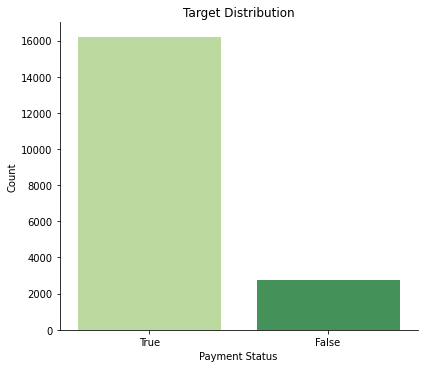

In [ ]:
# Plotting the count
sns.catplot(x='paid', 
            kind='count', 
            data=df_sorted, 
            palette='YlGn',
            order=df_sorted['paid'].value_counts().index,
            aspect=1.2)
plt.title('Target Distribution')
plt.xlabel("Payment Status")
plt.ylabel("Count")
plt.show()

We can see clearly that our target variable is imbalanced.

#### Numeric Variables

['amount', 'recharge_value', 'balance_after_recharge',       'time_to_pay_float', 'mean_time_to_pay', 'mean_amount',         'last_loan_range_float', 'missed_percentage', 'balance']

In [ ]:
# Creating a function to print descriptive statistics of our variables
def print_desc_stat(variable):
  x = variable

  print('Descriptive Stats')
  print(f"Min - {df_sorted[x].min()}")
  print(f"Max - {df_sorted[x].max()}")
  print(f"Mean - {round(df_sorted[x].mean(), 2)}")
  print(f"Median - {df_sorted[x].median()}")
  print(f"Mode - {df_sorted[x].mode()[0]}")
  print(f"Std - {round(df_sorted[x].std(), 2)}")

#### Variable 'amount'

In [ ]:
# Analyzing variable characteristics
print_desc_stat('amount')

Descriptive Stats
Min - 3.85
Max - 10.0
Mean - 5.55
Median - 5.0
Mode - 5.0
Std - 1.57


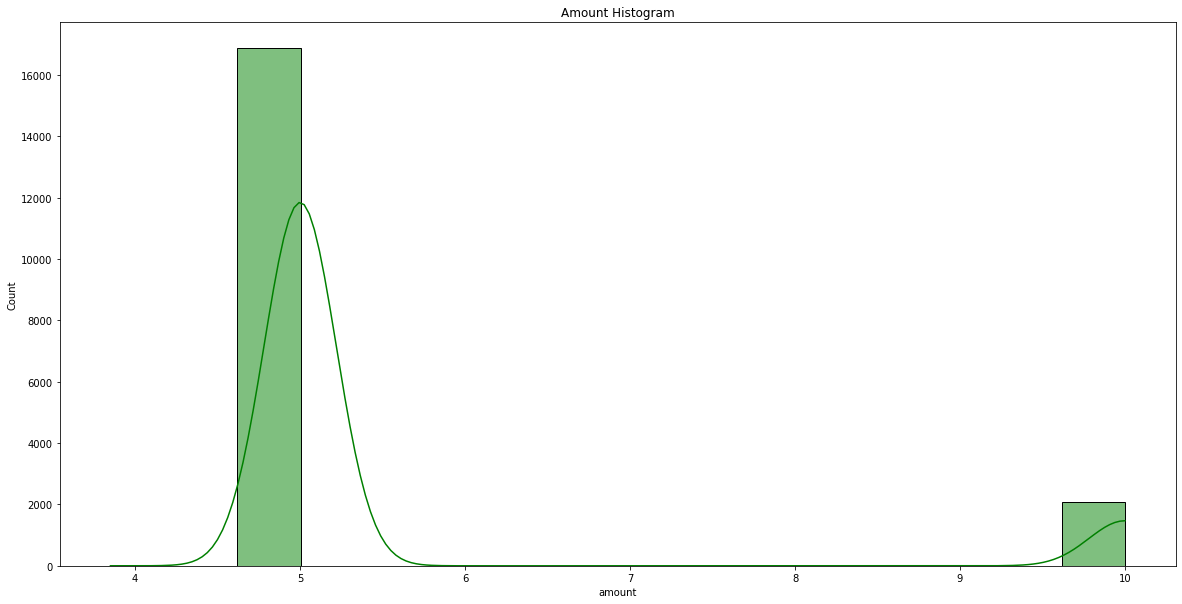

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted, x="amount", kde=True, color='green')
plt.title('Amount Histogram')
plt.show()

We could consider it a categoric variable with predefined classes of recharge amount.

Another imbalanced variable with 5.0 being the majority of the amounts

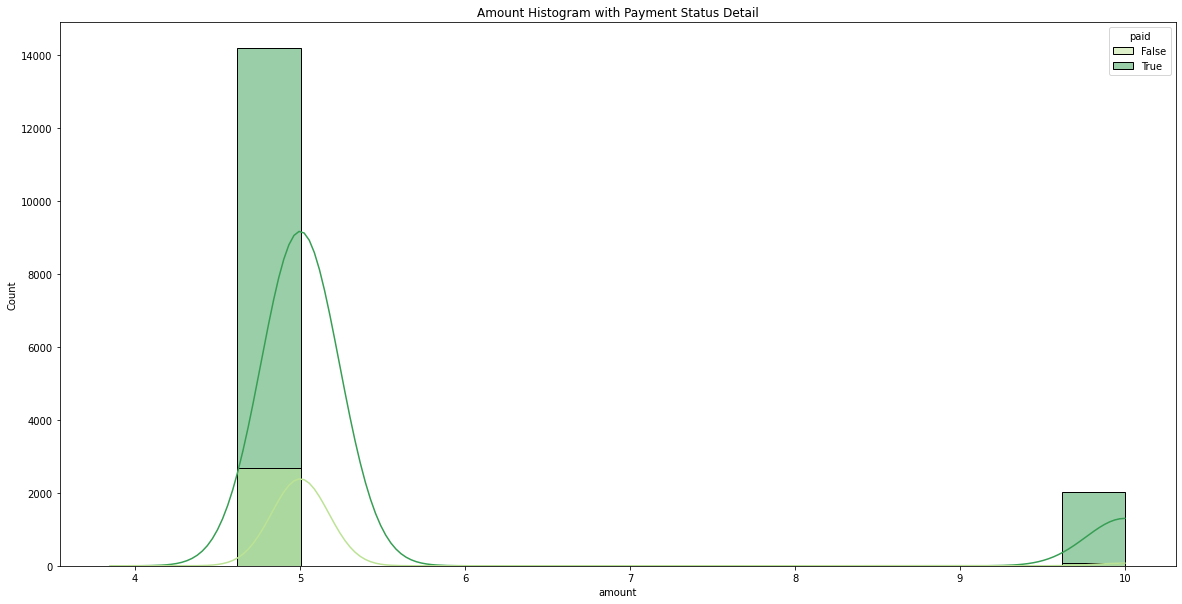

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted, x="amount", kde=True, palette='YlGn', hue='paid')
plt.title('Amount Histogram with Payment Status Detail')
plt.show()

The delinquency ratio is a lot higher on the 5.0 amount recharges!

#### Variable 'recharge_value'

Recharge value is actually the same as amount so we are going to skip this one.

#### Variable 'time_to_pay_float'

In [ ]:
# Analyzing variable characteristics
print_desc_stat('time_to_pay_float')

Descriptive Stats
Min - 0.12926815737268518
Max - 107.11774988667824
Mean - 12.33
Median - 6.984462151388889
Mode - 14.57463778226852
Std - 14.29


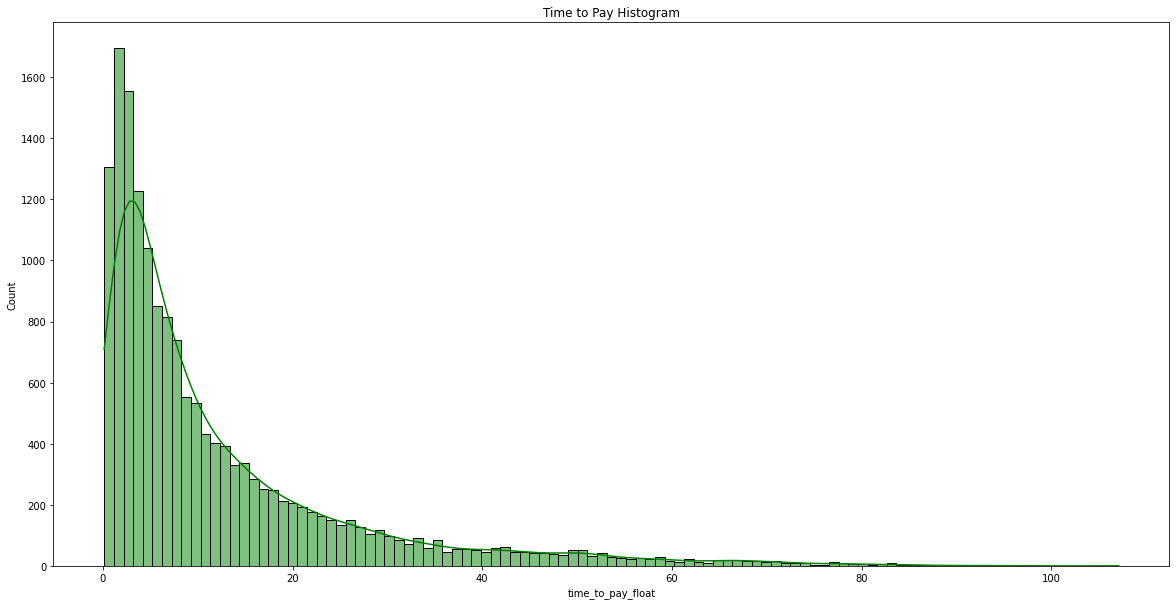

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted, x="time_to_pay_float", kde=True, color='green')
plt.title('Time to Pay Histogram')
plt.show()

Time to pay has a right skewed distribution which would probably need a data transformation if we were not planning to use tree based 

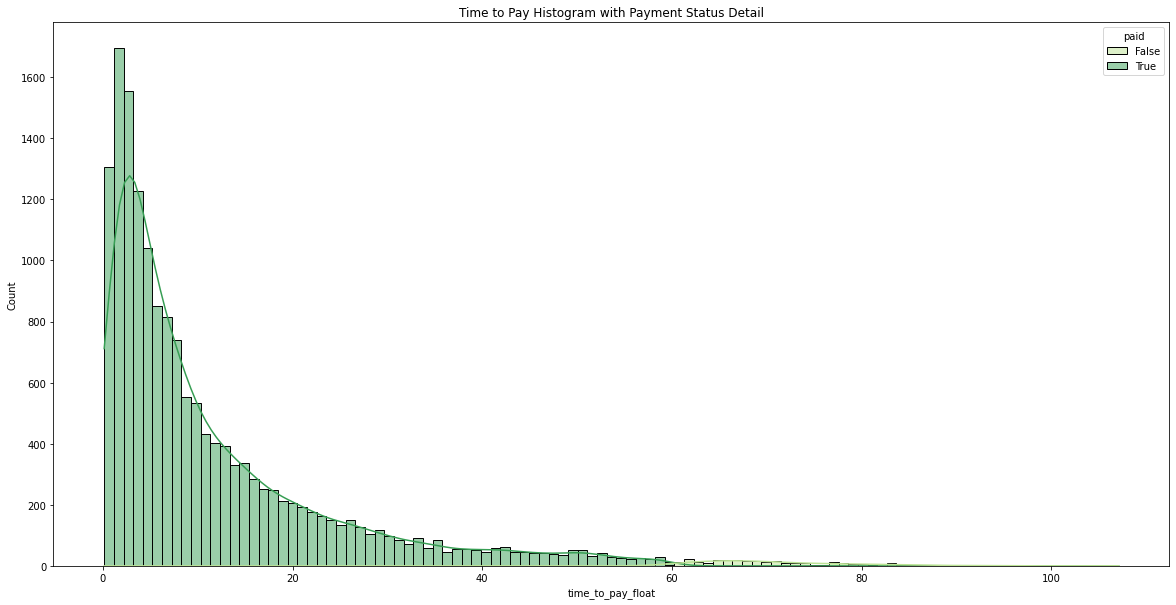

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted, x='time_to_pay_float', kde=True, palette='YlGn', hue='paid')
plt.title('Time to Pay Histogram with Payment Status Detail')
plt.show()

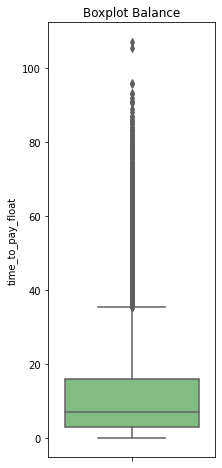

In [ ]:
# Plotting a BoxPlot to better understand the distribution
plt.figure(figsize=(3,8))
ax = sns.boxplot(data = df_sorted, y='time_to_pay_float', orient = 'v', color='blueviolet', palette='YlGn')
plt.title('Boxplot Balance')
plt.show()

As we already saw on the histogram, right skewed considering lot of the variables outliers.

#### Variable 'mean_time_to_pay'

In [ ]:
# Analyzing variable characteristics
print_desc_stat('mean_time_to_pay')

Descriptive Stats
Min - 0.12999363974537037
Max - 107.11774988667824
Mean - 9.0
Median - 5.712620467103601
Mode - 0.12999363974537037
Std - 10.11


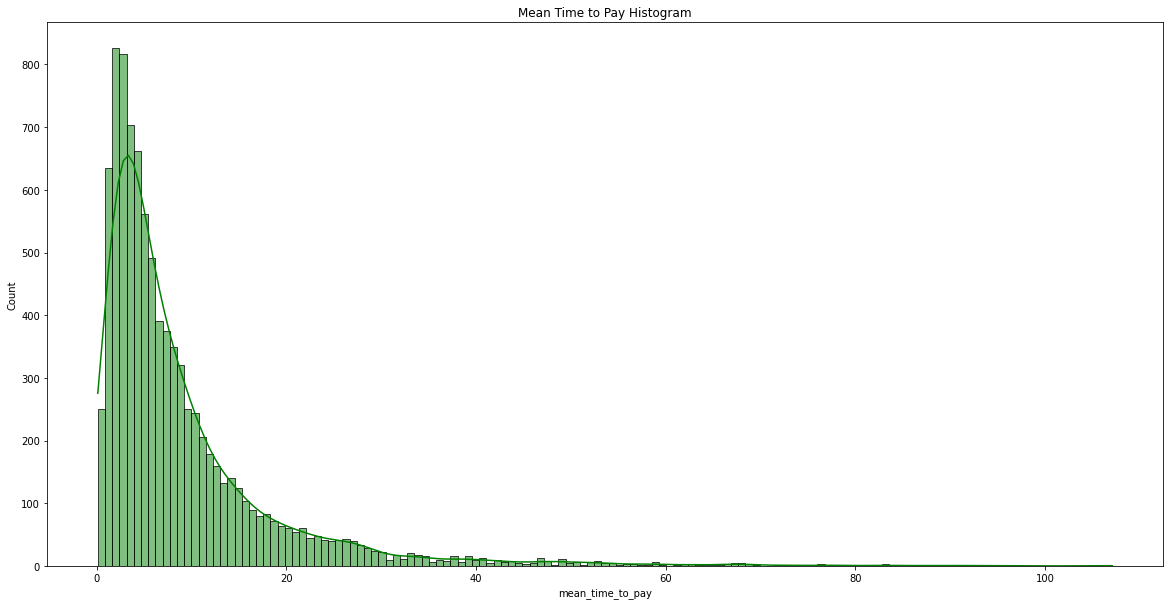

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted, x="mean_time_to_pay", kde=True, color='green')
plt.title('Mean Time to Pay Histogram')
plt.show()

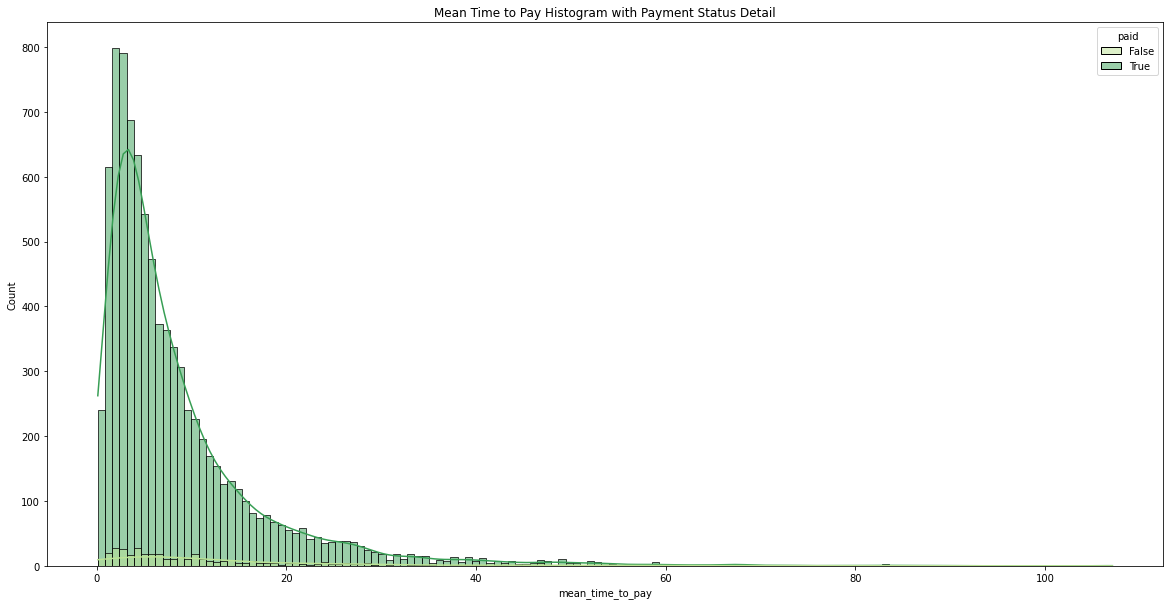

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted, x="mean_time_to_pay", kde=True, palette='YlGn', hue='paid')
plt.title('Mean Time to Pay Histogram with Payment Status Detail')
plt.show()

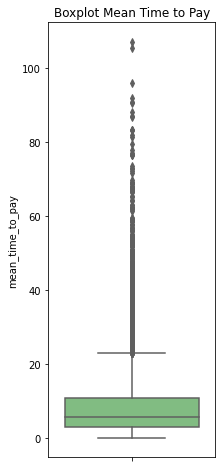

In [ ]:
# Plotting a BoxPlot to better understand the distribution
plt.figure(figsize=(3,8))
ax = sns.boxplot(data = df_sorted, y='mean_time_to_pay', orient = 'v', color='blueviolet', palette='YlGn')
plt.title('Boxplot Mean Time to Pay')
plt.show()

Mean time to pay follows the same behavior of time to pay, as expected.

#### Variable 'missed_percentage'

In [ ]:
# Analyzing variable characteristics
print_desc_stat('missed_percentage')

Descriptive Stats
Min - 0.0
Max - 1.0
Mean - 0.02
Median - 0.0
Mode - 0.0
Std - 0.11


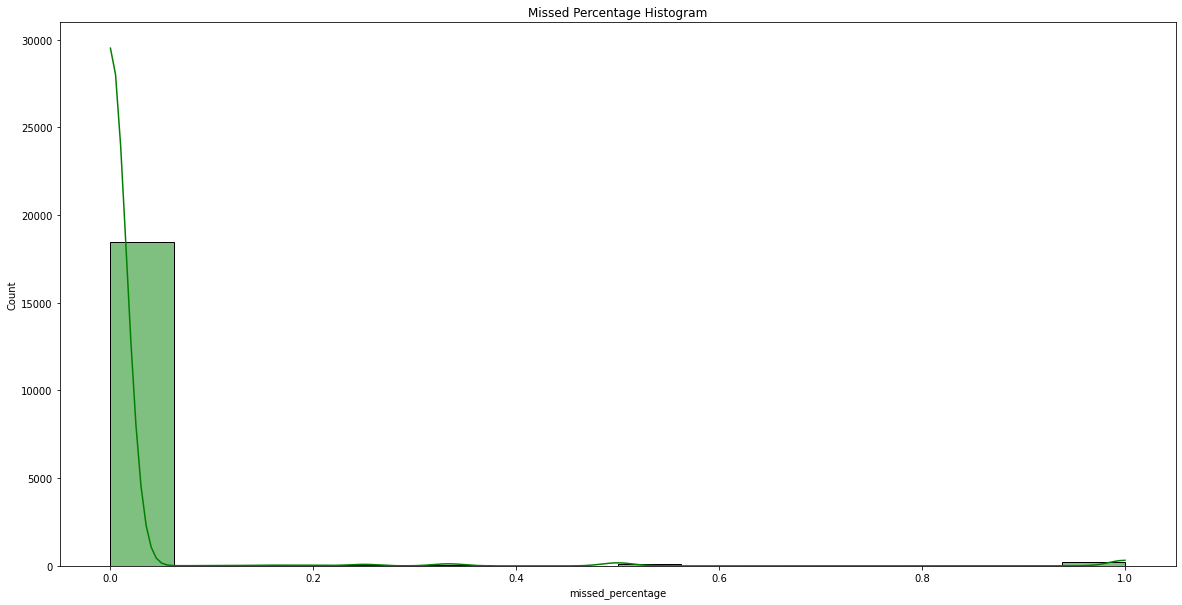

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted, x="missed_percentage", kde=True, color='green')
plt.title('Missed Percentage Histogram')
plt.show()

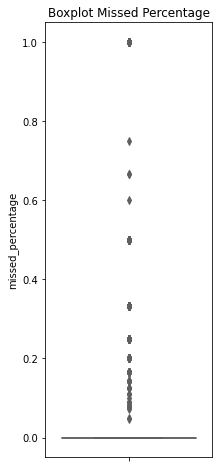

In [ ]:
# Plotting a BoxPlot to better understand the distribution
plt.figure(figsize=(3,8))
ax = sns.boxplot(data = df_sorted, y='missed_percentage', orient = 'v', color='blueviolet', palette='YlGn')
plt.title('Boxplot Missed Percentage')
plt.show()

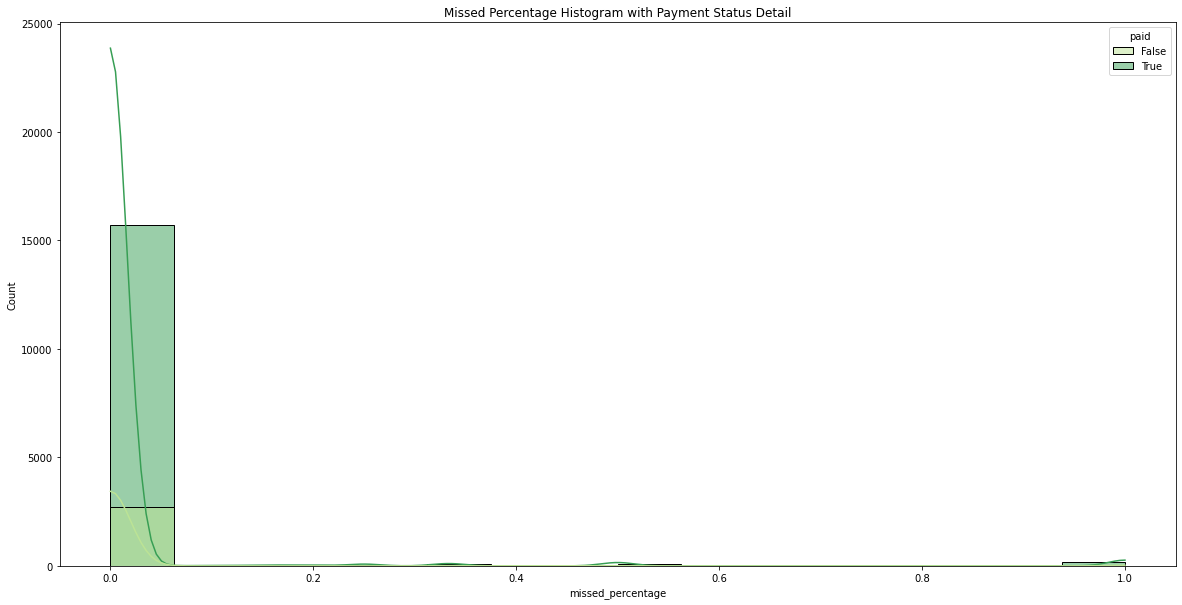

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted, x="missed_percentage", kde=True, palette='YlGn', hue='paid')
plt.title('Missed Percentage Histogram with Payment Status Detail')
plt.show()

We could not conclude much since most of the data we have is related to first-time users (Who have 0% of missing ratio) or users that didn't miss a payment

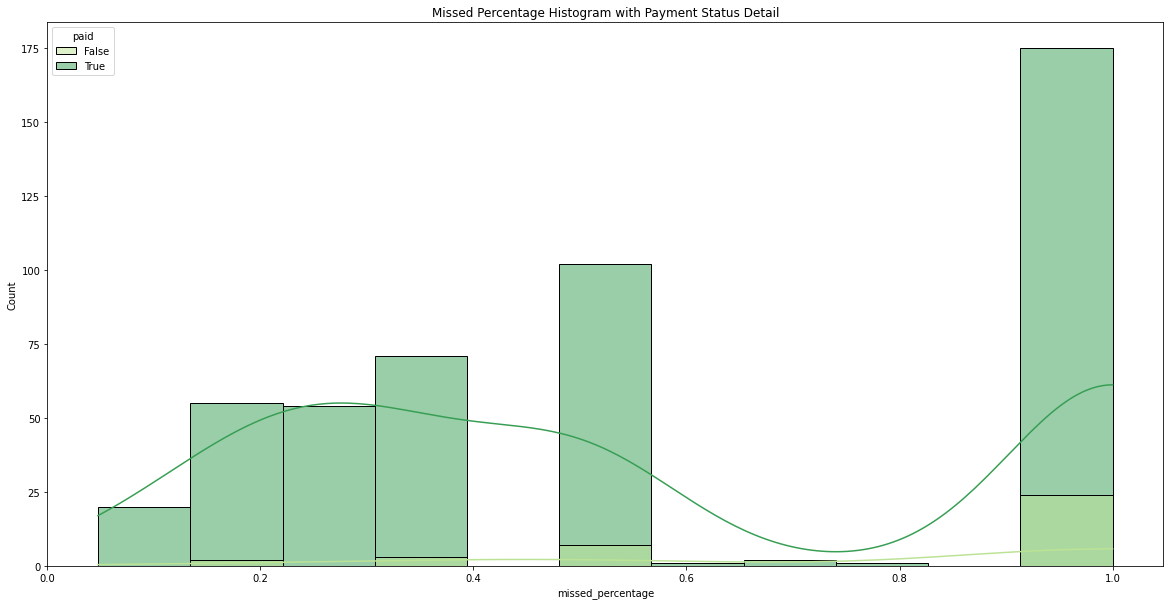

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted[df_sorted.missed_percentage > 0], x="missed_percentage", kde=True, palette='YlGn', hue='paid')
plt.title('Missed Percentage Histogram with Payment Status Detail')
plt.show()

Removing all the 0% missed percentages mentioned above to have a better understanding of other cases.


As expected, the delinquency increases as the missed percentage increases, with an interesting observation that 20% has a higher delinquency rate than 30%.

#### Variable 'balance_after_recharge'

In [ ]:
# Analyzing variable characteristics
print_desc_stat('balance_after_recharge')

Descriptive Stats
Min - 5.0
Max - 190.36
Mean - 7.16
Median - 5.57
Mode - 5.0
Std - 4.17


Our max value already shows us the presence of outliers.


We are going to adjust our df closes to our mean and median so that we can better visualize the next plots.

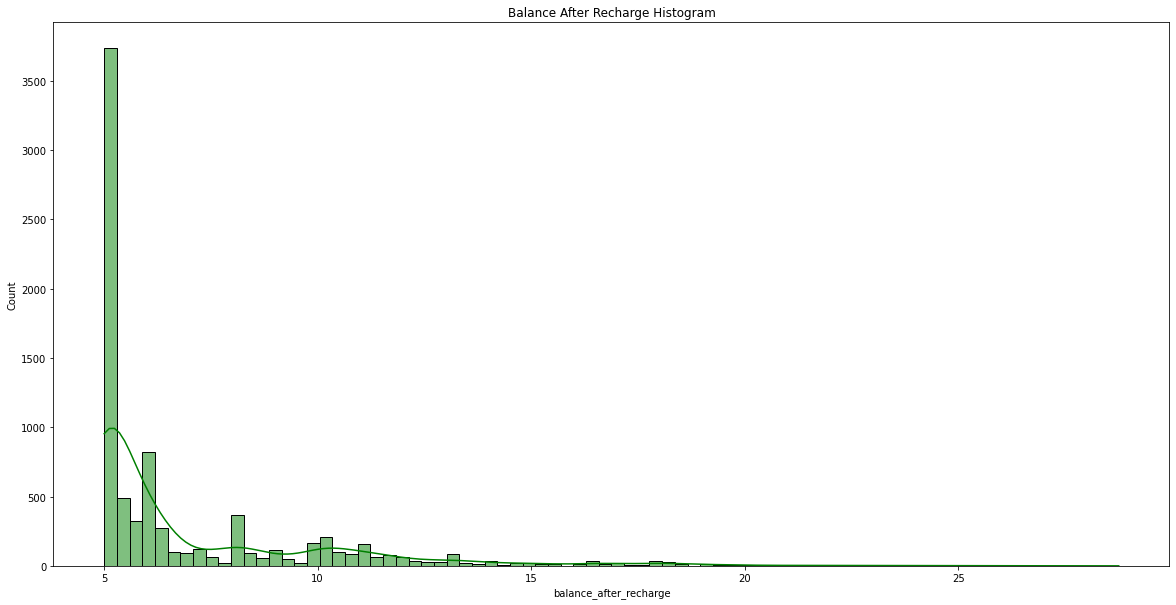

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted[df_sorted.balance_after_recharge < 30], x="balance_after_recharge", kde=True, color='green')
plt.title('Balance After Recharge Histogram')
plt.show()

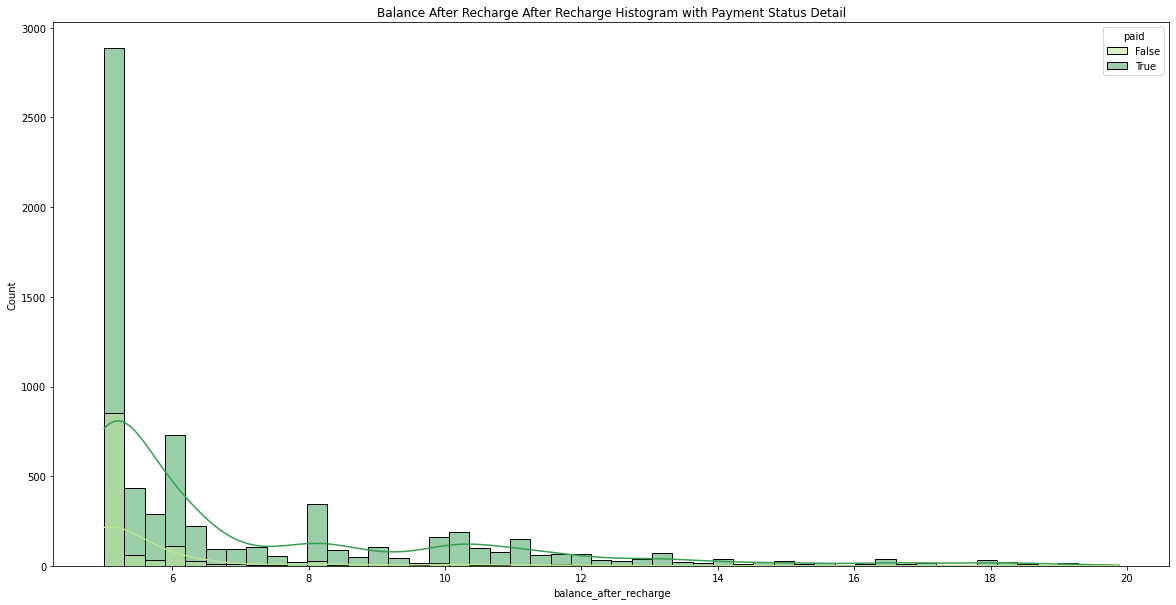

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted[df_sorted.balance_after_recharge < 20], x="balance_after_recharge", kde=True, palette='YlGn', hue='paid')
plt.title('Balance After Recharge After Recharge Histogram with Payment Status Detail')
plt.show()

The main source of delinquency is the id who uses all of the balance and then gets the minimun value of recharge.

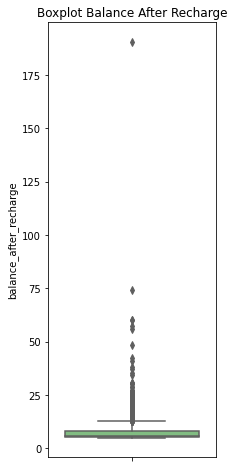

In [ ]:
# Plotting a BoxPlot to better understand the distribution
plt.figure(figsize=(3,8))
ax = sns.boxplot(data = df_sorted, y='balance_after_recharge', orient = 'v', color='blueviolet', palette='YlGn')
plt.title('Boxplot Balance After Recharge')
plt.show()

The boxplot shows us the 190 as a clear outlier and some other values that are more common but also outliers considering the median of our distribution is around 5,5.

#### Variable 'balance'

In [ ]:
# Analyzing variable characteristics
print_desc_stat('balance')

Descriptive Stats
Min - 0.0
Max - 185.36
Mean - 1.61
Median - 0.41000000000000014
Mode - 0.0
Std - 3.77


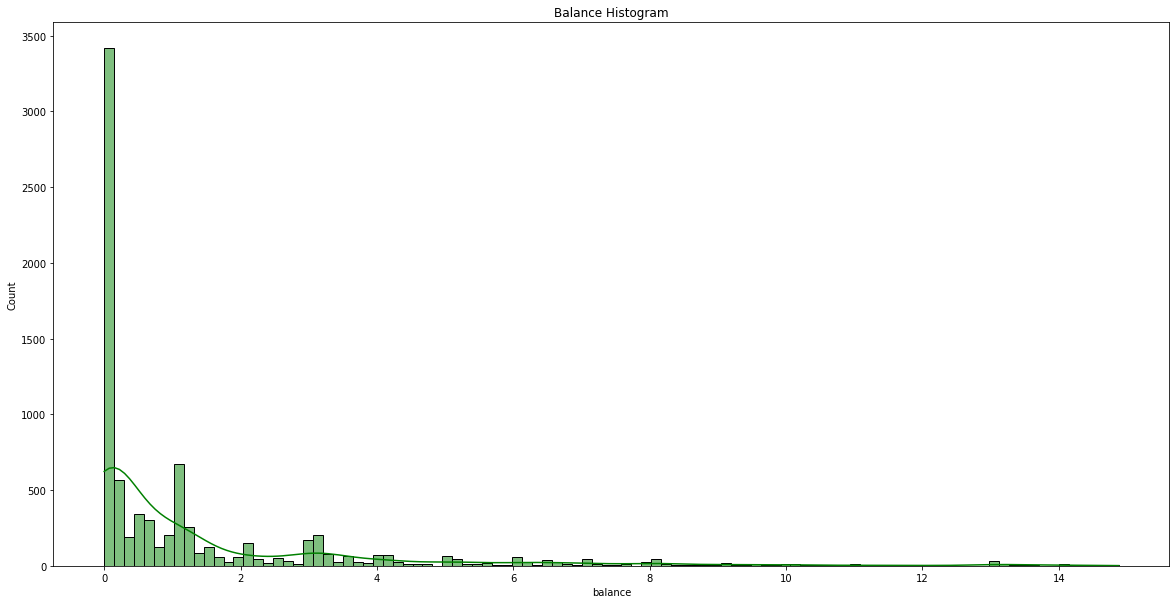

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted[df_sorted.balance < 15], x="balance", kde=True, color='green')
plt.title('Balance Histogram')
plt.show()

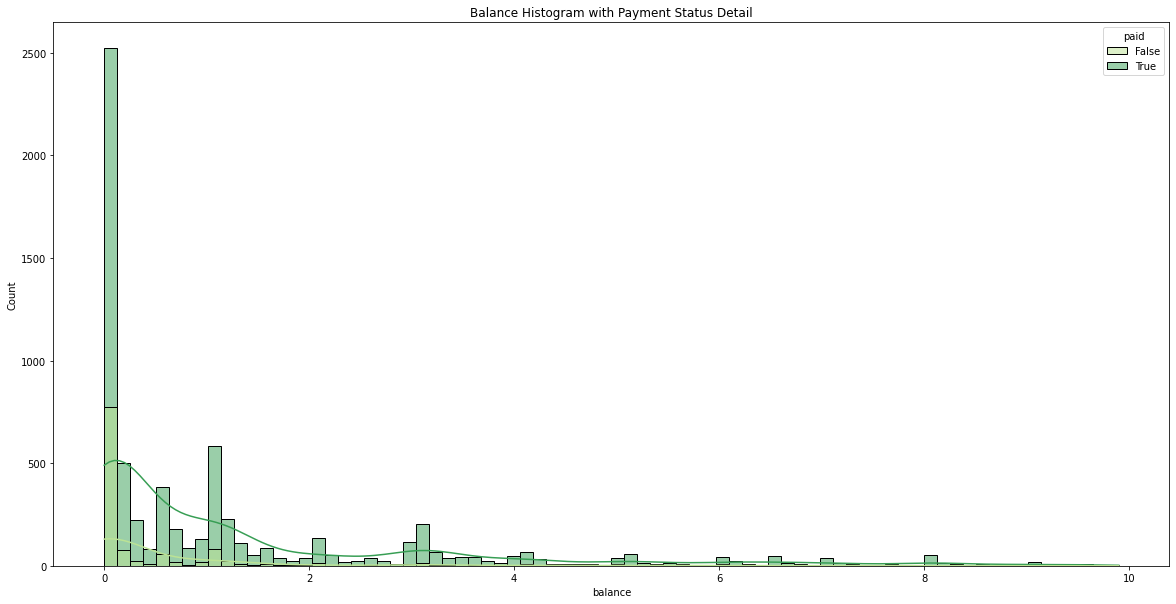

In [ ]:
# Plotting histogram
plt.figure(figsize=(20,10))
sns.histplot(data=df_sorted[df_sorted.balance < 10], x="balance", kde=True, palette='YlGn', hue='paid')
plt.title('Balance Histogram with Payment Status Detail')
plt.show()

Running out of credits again showing itself as a big source of delinquency.

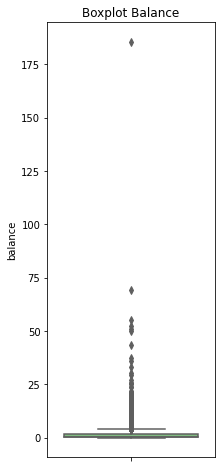

In [ ]:
# Plotting a BoxPlot to better understand the distribution
plt.figure(figsize=(3,8))
ax = sns.boxplot(data = df_sorted, y='balance', orient = 'v', color='blueviolet', palette='YlGn')
plt.title('Boxplot Balance')
plt.show()

As expected, same behavior as the balance after recharge.

### Bivariate and multivariate analysis

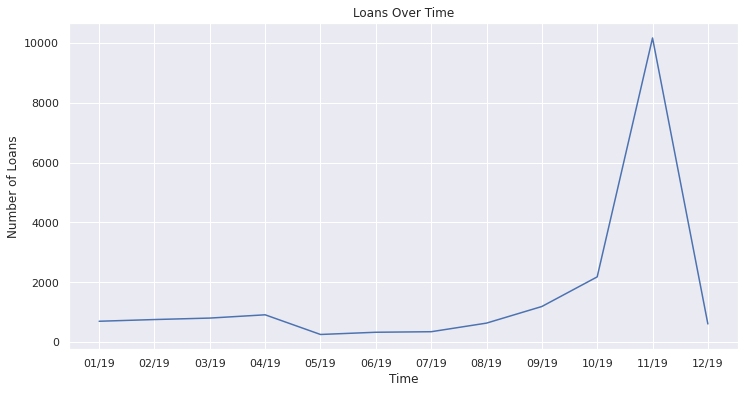

In [ ]:
# Defining an auxiliar df to plot over time
data_viz = df_sorted[['created_at', 'loan_id']]

# Defining granularity of time (monthly)
data_viz['created_at'] = data_viz.created_at.dt.strftime('%m/%y')

# Grouping data to get the count
data_viz = data_viz.groupby(['created_at'], as_index=False)['loan_id'].count()

# Plotting the n of loans over time
sns.set(rc = {'figure.figsize':(12,6)})

sns.lineplot(data=data_viz,
            x="created_at",
            y="loan_id",
            palette='YlGn')
plt.title('Loans Over Time')
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.show()

Number of loans with a clear spike on November

In [ ]:
# Modifying our payment status column ('paid') so that we can visualize correlation with numerical features
df_sorted.paid = df_sorted.paid.map({False:0, True:1})

# Modifying the lag of our payment status column ('lag_paid') so that we can visualize correlation with numerical features
df_sorted.lag_paid = df_sorted.lag_paid.map({False:0, True:1})

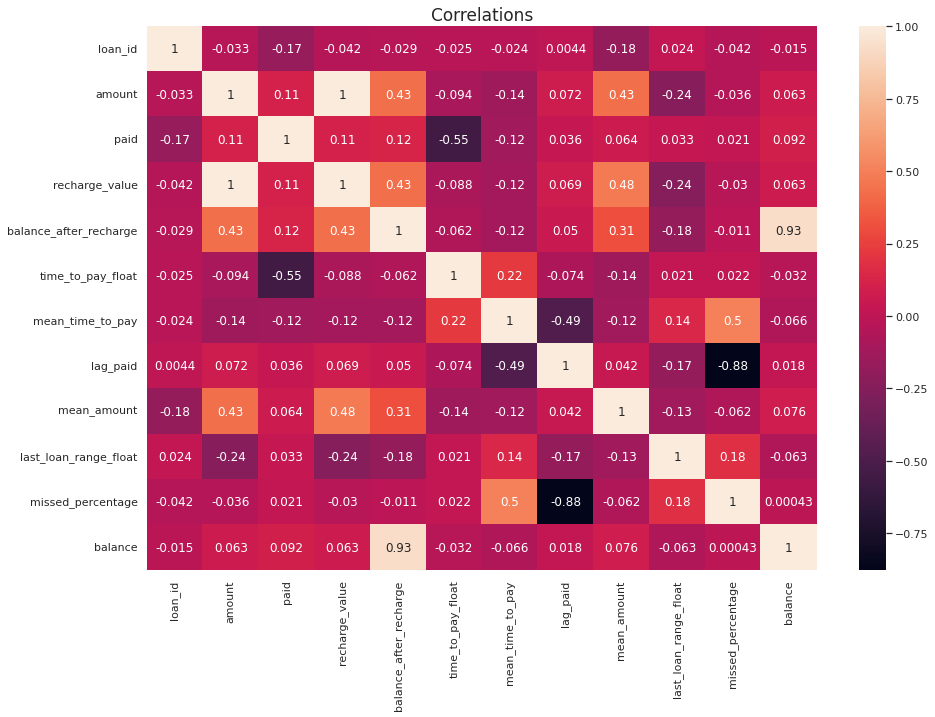

In [ ]:
# Verifying correlations
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df_sorted.corr(), annot=True)
ax.set_title('Correlations', fontsize=17);

Best correlations are around 0.1, let's see if it takes us somewhere.

* The -0.55 correlation of 'paid' with 'time_to_pay' is related to data leakage since we created this column just to be able to create the feature 'mean_time_to_pay' in which we use shift and remove the current 'paid_at' information.
* We have to be aware of the correlation between some of our new features which can be really similar because of our data or the similarity in the calculation.


We are going to use  **amount, mean time to pay, balance, last loan range and missed percentage or lag of payment status.**


Among the discarded features most of them are explained by the **lack of data** (for example mean amount could give a valueable information about user previous behavior vs current behavior when compared to amount, the same would be possible with balance and a calculated mean balance column, but the current data it **does not allow us to go deep** into our **users' behavior**!

## **Model Training**

Our data has some **missing values** main related to the **lack of historical data** and skewed distributions. For our purpose in the test, we are going to consider certain implementations of tree-based models that are able to handle incomplete data and also the characteristics of our features better than other models.

Histogram based Gradient-boosting Classifier is one example with native support for missing values and we are going to compare it to XGBoost and CatBoost.

In [ ]:
# Defining target
y = df_sorted['paid']

In [ ]:
# Defining predictors
X = df_sorted[['amount', 'mean_time_to_pay','balance', 'last_loan_range_float', 'lag_paid']]

In [ ]:
# Splitting data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state=0)

In [ ]:
# Importing, fitting and training the models
xgb_clf = XGBClassifier().fit(X_train, y_train)
cat_clf = CatBoostClassifier().fit(X_train, y_train)
hgb_clf = HistGradientBoostingClassifier().fit(X_train, y_train)

classifiers = [xgb_clf, cat_clf, hgb_clf]

Learning rate set to 0.031077
0:	learn: 0.6675341	total: 60.8ms	remaining: 1m
1:	learn: 0.6440746	total: 66.2ms	remaining: 33s
2:	learn: 0.6224312	total: 71.8ms	remaining: 23.9s
3:	learn: 0.6025847	total: 81.7ms	remaining: 20.3s
4:	learn: 0.5839432	total: 86.7ms	remaining: 17.3s
5:	learn: 0.5675803	total: 89.4ms	remaining: 14.8s
6:	learn: 0.5523470	total: 93ms	remaining: 13.2s
7:	learn: 0.5377970	total: 98.3ms	remaining: 12.2s
8:	learn: 0.5241753	total: 104ms	remaining: 11.4s
9:	learn: 0.5120167	total: 109ms	remaining: 10.8s
10:	learn: 0.5005103	total: 114ms	remaining: 10.2s
11:	learn: 0.4904407	total: 119ms	remaining: 9.79s
12:	learn: 0.4811191	total: 124ms	remaining: 9.38s
13:	learn: 0.4721537	total: 129ms	remaining: 9.06s
14:	learn: 0.4645900	total: 132ms	remaining: 8.65s
15:	learn: 0.4575887	total: 136ms	remaining: 8.34s
16:	learn: 0.4509989	total: 139ms	remaining: 8.06s
17:	learn: 0.4447777	total: 144ms	remaining: 7.88s
18:	learn: 0.4393385	total: 147ms	remaining: 7.61s
19:	learn:

## **Applying model to holdout (test) set**

In [ ]:
# Applying and evaluating models
for clf in classifiers:
  y_pred = clf.predict(X_test)
  y_score = clf.predict_proba(X_test)[:,1]
  print(clf.__class__.__name__)
  print('Precision - ', metrics.precision_score(y_test, y_pred))
  print('Recall - ', metrics.recall_score(y_test, y_pred))
  print('F1 - ', metrics.f1_score(y_test, y_pred))
  print('ROC_AUC - ', metrics.roc_auc_score(y_test, y_score))
  print('======\n')

XGBClassifier
Precision -  0.8565653014589559
Recall -  1.0
F1 -  0.9227419049422458
ROC_AUC -  0.7619317427360847

CatBoostClassifier
Precision -  0.8565891472868217
Recall -  0.9977426636568849
F1 -  0.921793534932221
ROC_AUC -  0.7560273596407577

HistGradientBoostingClassifier
Precision -  0.8565400843881856
Recall -  0.9997947876051714
F1 -  0.9226399015244768
ROC_AUC -  0.7575170356466001



The results seem to be inflated because of our imbalanced distributions. Another misleading point could be the large amount of missing data! ROC AUC is a robust metric against not well distributed classes and it can be the sign that the other metrics are inflated.


We can try to treat the missing values and/or balance the data to see what happens!

In [ ]:
# Checking number of nans of each features
for col in X.columns:
  print(X[f'{col}'].isna().sum())

0
9710
10674
9513
9513


All the new features have many missing values, we can try input the data ocurrences and check again the count.


Dropping would cost too much since it represents more than half of the data in some cases!

In [ ]:
# Filling missing values so that we can retrain our model 
for col in ['mean_time_to_pay','balance', 'last_loan_range_float', 'lag_paid']:
    X[col].fillna(X[col].median(), inplace=True)

It is not the best approach because it does not factor the correlations between features but it is easy, fast and is not computationally expensive such as an inputation algorithm based.

In [ ]:
# Checking number of nans of each features
for col in X.columns:
  print(X[f'{col}'].isna().sum())

0
0
0
0
0


### Retraining our model

Since we now have no missing values and the simple imputation does not factor the correlations between features (our results with tree based models probably won't change since the decision parameters will remain a standard single value), we are going to add different models to the mix.

In [ ]:
# Importing new modelling libs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Splitting data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state=0)

In [ ]:
# Importing, fitting and training the models
xgb_clf = XGBClassifier().fit(X_train, y_train)
cat_clf = CatBoostClassifier().fit(X_train, y_train)
hgb_clf = HistGradientBoostingClassifier().fit(X_train, y_train)
log_clf = LogisticRegression().fit(X_train, y_train)
kn_clf = KNeighborsClassifier(3).fit(X_train, y_train)


classifiers = [xgb_clf, cat_clf, hgb_clf, log_clf, kn_clf]

Learning rate set to 0.031077
0:	learn: 0.6677137	total: 5.27ms	remaining: 5.26s
1:	learn: 0.6438086	total: 9.85ms	remaining: 4.92s
2:	learn: 0.6220388	total: 14.5ms	remaining: 4.81s
3:	learn: 0.6062144	total: 17.4ms	remaining: 4.34s
4:	learn: 0.5923092	total: 20.6ms	remaining: 4.1s
5:	learn: 0.5759648	total: 25ms	remaining: 4.15s
6:	learn: 0.5599182	total: 29.9ms	remaining: 4.24s
7:	learn: 0.5444002	total: 34.9ms	remaining: 4.32s
8:	learn: 0.5342584	total: 38.2ms	remaining: 4.21s
9:	learn: 0.5226900	total: 43ms	remaining: 4.26s
10:	learn: 0.5113447	total: 47.8ms	remaining: 4.3s
11:	learn: 0.5003987	total: 52.6ms	remaining: 4.33s
12:	learn: 0.4920617	total: 56ms	remaining: 4.25s
13:	learn: 0.4838873	total: 59.6ms	remaining: 4.2s
14:	learn: 0.4752419	total: 65ms	remaining: 4.26s
15:	learn: 0.4690899	total: 67.9ms	remaining: 4.18s
16:	learn: 0.4614528	total: 72.9ms	remaining: 4.22s
17:	learn: 0.4555534	total: 76.7ms	remaining: 4.18s
18:	learn: 0.4487871	total: 81.5ms	remaining: 4.21s
19:

In [ ]:
# Applying and evaluating models
for clf in classifiers:
  y_pred = clf.predict(X_test)
  y_score = clf.predict_proba(X_test)[:,1]
  print(clf.__class__.__name__)
  print('Precision - ', metrics.precision_score(y_test, y_pred))
  print('Recall - ', metrics.recall_score(y_test, y_pred))
  print('F1 - ', metrics.f1_score(y_test, y_pred))
  print('ROC_AUC - ', metrics.roc_auc_score(y_test, y_score))
  print('======\n')

XGBClassifier
Precision -  0.8565653014589559
Recall -  1.0
F1 -  0.9227419049422458
ROC_AUC -  0.7600010864185609

CatBoostClassifier
Precision -  0.8565645899331221
Recall -  0.9987687256310281
F1 -  0.9222169587873046
ROC_AUC -  0.7558620077417382

HistGradientBoostingClassifier
Precision -  0.8565653014589559
Recall -  1.0
F1 -  0.9227419049422458
ROC_AUC -  0.7540793508045533

LogisticRegression
Precision -  0.8565653014589559
Recall -  1.0
F1 -  0.9227419049422458
ROC_AUC -  0.6190038245957115

KNeighborsClassifier
Precision -  0.8559185859667916
Recall -  0.9837882208085368
F1 -  0.9154095856406339
ROC_AUC -  0.6647361360920317



The inflated metrics still suggests our imbalanced dataset could be misleading us. Let's look at an over sampling and/or under sampling strategy.

In [ ]:
# Looking at data before balancing
y.value_counts()

1    16195
0     2767
Name: paid, dtype: int64

I think we do not have too much data and randomly under sampling or dropping the 1 examples using a missing valuw strategy could cost us a lot o good information or introduce bias.

We are goint to over sample our data.

In [ ]:
# Applying SMOTE to balance our data
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
# Looking at data after balancing
y.value_counts()

0    16195
1    16195
Name: paid, dtype: int64

In [ ]:
# Splitting data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state=0)

In [ ]:
# Importing, fitting and training the models
xgb_clf = XGBClassifier().fit(X_train, y_train)
cat_clf = CatBoostClassifier().fit(X_train, y_train)
hgb_clf = HistGradientBoostingClassifier().fit(X_train, y_train)
log_clf = LogisticRegression().fit(X_train, y_train)
kn_clf = KNeighborsClassifier(3).fit(X_train, y_train)


classifiers = [xgb_clf, cat_clf, hgb_clf, log_clf, kn_clf]

Learning rate set to 0.03906
0:	learn: 0.6842900	total: 7.38ms	remaining: 7.37s
1:	learn: 0.6758814	total: 14.5ms	remaining: 7.24s
2:	learn: 0.6680120	total: 21.6ms	remaining: 7.18s
3:	learn: 0.6612226	total: 28.9ms	remaining: 7.21s
4:	learn: 0.6549386	total: 35.9ms	remaining: 7.14s
5:	learn: 0.6492870	total: 42.6ms	remaining: 7.05s
6:	learn: 0.6437670	total: 49.7ms	remaining: 7.06s
7:	learn: 0.6390256	total: 57ms	remaining: 7.07s
8:	learn: 0.6343673	total: 63.8ms	remaining: 7.03s
9:	learn: 0.6302983	total: 70.4ms	remaining: 6.97s
10:	learn: 0.6262199	total: 77.6ms	remaining: 6.98s
11:	learn: 0.6223691	total: 84.3ms	remaining: 6.94s
12:	learn: 0.6186288	total: 90.9ms	remaining: 6.9s
13:	learn: 0.6155334	total: 97.8ms	remaining: 6.89s
14:	learn: 0.6124634	total: 105ms	remaining: 6.91s
15:	learn: 0.6098587	total: 112ms	remaining: 6.88s
16:	learn: 0.6072940	total: 118ms	remaining: 6.85s
17:	learn: 0.6045724	total: 125ms	remaining: 6.83s
18:	learn: 0.6023396	total: 132ms	remaining: 6.81s
1

In [ ]:
# Applying and evaluating models
for clf in classifiers:
  y_pred = clf.predict(X_test)
  y_score = clf.predict_proba(X_test)[:,1]
  print(clf.__class__.__name__)
  print('Precision - ', metrics.precision_score(y_test, y_pred))
  print('Recall - ', metrics.recall_score(y_test, y_pred))
  print('F1 - ', metrics.f1_score(y_test, y_pred))
  print('ROC_AUC - ', metrics.roc_auc_score(y_test, y_score))
  print('======\n')

XGBClassifier
Precision -  0.7976321585903083
Recall -  0.600165734410607
F1 -  0.6849509398274027
ROC_AUC -  0.7759829571475718

CatBoostClassifier
Precision -  0.8340649692712906
Recall -  0.5904288377874456
F1 -  0.6914119359534205
ROC_AUC -  0.800112014770359

HistGradientBoostingClassifier
Precision -  0.8219497956800934
Recall -  0.583385125336648
F1 -  0.6824185144795831
ROC_AUC -  0.7892333639636958

LogisticRegression
Precision -  0.7671357240127099
Recall -  0.3501139424072923
F1 -  0.4807965860597439
ROC_AUC -  0.6191721922061614

KNeighborsClassifier
Precision -  0.8225900116144018
Recall -  0.5869069815620468
F1 -  0.6850441300930964
ROC_AUC -  0.7725978572303119



## **Results**

After balancing the data with SMOTE (Synthetic Minority Over-sampling Technique) which is a method that combines a KNN aproach with vectorization to guide the creation of the new points and not a simple random oversample. Our models seem to have a more factible result.


One unexpected/unplaned point of our conclusion is that our goal was to predict delinquency probability, which in our case is the 0/Negative response to our payment status target variable called 'paid', considering that, Specificity (True Negative Rate) would be a good main metric here.

In [ ]:
# Applying and evaluating models to calculate our new main metric
for clf in classifiers:
  y_pred = clf.predict(X_test)
  y_score = clf.predict_proba(X_test)[:,1]
  print(clf.__class__.__name__)
  tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
  print('Specificity - ', (tn/(fp + tn)))
  print('======\n')

XGBClassifier
Specificity -  0.8496932515337423

CatBoostClassifier
Specificity -  0.8840490797546012

HistGradientBoostingClassifier
Specificity -  0.8752556237218814

LogisticRegression
Specificity -  0.8950920245398774

KNeighborsClassifier
Specificity -  0.8750511247443763



According to the Specificity metric, the model that best measures how many negatives (delinquency cases) we classified correctly, is Logistic Regression!! CatBoost would be a second model to consider because of the small difference on Specificity but much better ROC-AUC.

A great next step for this experiment would be to include more historical data so that the amount of missing values from calculations would decrease. And after that a more robust approach to handle the still missing data.